## Klasteryzacja
#### Czym jest klasteryzacja?
Najprościej — szukaniem skupień (klastrów).
![](https://miro.medium.com/max/561/0*ff7kw5DRQbs_uixR.jpg)
<div align="center">Żródło: https://www.kdnuggets.com/2019/09/hierarchical-clustering.html</div>

#### Po co?
* Aby znaleźć „naturalne” podziały w zbiorze.
* Aby zaproponować podział na klasy.
* Aby ułatwić opis (klastrom można przyporządkować etykiety i do pewnego stopnia traktować jako całość).
* ...

#### Czym właściwie jest klaster?
Nie mamy jednej definicji. Na ogół — grupa podobnych obiektów. Różne algorytmy rożnie „rozumieją” podobieństwo i różnie go szukają.

Zasadniczo metody dzielimy na metody hierarchiczne i kombinatoryczne. Zacznijmy od kombinatorycznych.

### Metoda k-średnich
Pomysł jest prosty:
1. Zakładamy, że w zbiorze jest k klastrów.
2. Wybieramy k punktów będącymi początkowymi położeniami środków naszych klastrów.
![](https://upload.wikimedia.org/wikipedia/commons/5/5e/K_Means_Example_Step_1.svg)
3. Określamy przynależność do klastrów jako przynależność do klastra „generowanego” przez najbliższy środek.
![](https://upload.wikimedia.org/wikipedia/commons/a/a5/K_Means_Example_Step_2.svg)
4. Aktualizujemy położenie środków klastrów jako środek masy punków należących do klastra.
![](https://upload.wikimedia.org/wikipedia/commons/3/3e/K_Means_Example_Step_3.svg)
5. Sprawdzamy, czy przynależność jakiegokolwiek punktu zmieniła się po wyznaczeniu nowych środków. Jeśli tak — wracamy do punktu 3. Jeśli nie — kończymy działanie.

Źródło ilustracji: https://en.wikipedia.org/wiki/K-means_clustering

Działanie algorytmu wygląda następująco:
![](https://miro.medium.com/max/960/1*KrcZK0xYgTa4qFrVr0fO2w.gif)
<div align="center">Źródło: https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68</div>

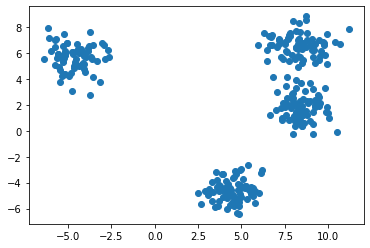

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.9, random_state=314)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [2]:
from sklearn.cluster import KMeans

def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()

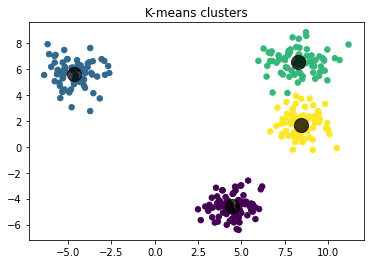

In [3]:
plot_kmeans_clusters(X, n_clusters=4)

#### A co jeśli podamy złe k?

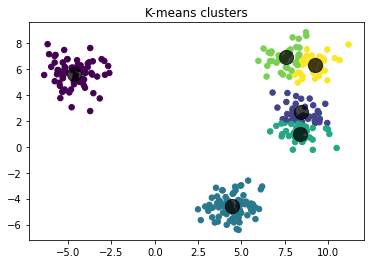

In [4]:
plot_kmeans_clusters(X, n_clusters=6)

### Zatem jak dobrać liczbę skupień?

#### Metoda łokcia
Zacznijmy od tego, że algorytm k-średnich minimalizuję wewnątrzklastrową sumę kwadratów (ang. <em>within-cluster sum of squares</em>):

$$\underset{\mathbf{S}}{\operatorname{argmin}}\sum_{i=1}^{k}\sum_{\mathbf{x} \in S_i} {\lVert \mathbf{x} - \mu_i \rVert^2} = \underset{\mathbf{S}}{\operatorname{argmin}}\sum_{i=1}^{k} \# S_i \mathrm{Var} (S_i)
$$

Liczymy sumę odległości punktu od środka skupienia (możemy tutaj użyć różnych metryk, my zastosujemy kwadrat odległości $L_2$, ponieważ jest to naturalna metryka dla naszego algorytmu). Rysujemy wykres tejże odległości w zależności od liczby klastrów i wybieramy punkt „przegięcia”. Wygląda on jak łokieć — stąd nazwa metody.

In [5]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

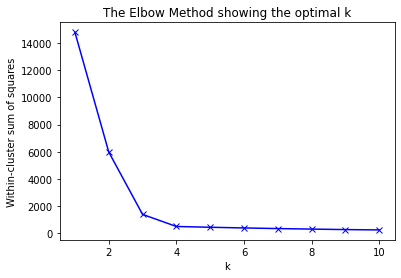

In [6]:
wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Oczywiście jest to metoda subiektywna i czasami wybór łokcia jest nieoczywisty. Dlatego często stosuje się inną metodę:

#### Metoda silhouette

Zdefiniujmy:
$$ a(i) := \frac{1}{\# C(i)  -1 } \sum_{j \in C(i), i \neq j} d(i, j)  $$
Gdzie:  
$i$ — indeks punktu,  
$C(i)$ — klaster, do którego należy $i$-ty punkt,  
$d(i, j)$ — odległość między $i$-tym i $j$-tym punktem.

Liczbę $a$ możemy interpretować jako średnią odległość od punktu w tym samym klastrze.

$$ b(i) := \underset{k: C_k \bigcap C(i) = \emptyset}{min} \frac{1}{\# C_k} \sum_{j \in C_k} d(i, j) $$
$C_k$ to $k$-ty klaster. Nie mylić z oznaczeniem $C(i)$, czyli klastrem, do którego należy $i$-ty punkt.


Liczba $b$ to po prostu średnia odległość od punktów tego klastra, który jest „drugim najlepszym” dla $i$-tego punktu.  

Jeśli $\# C(i) \neq 1$ definiujemy:  
$$ s(i) := \frac{b(i) - a(i)}{\max{ \{ a(i), b(i) \} }} $$
Dla kompletności dodajmy, że jeśli $\# C(i) = 1$, wtedy:
$$ s(i) := 0 $$
Zatem $s(i)$ mówi nam o tym, jak dobrze dany punkt pasuje do klastra, do którego został przyporządkowany w porównaniu z tym klastrem, który jest „drugim wyborem".

Ostatecznie nasza miara silhouette to średnia $s(i)$ po wszystkich punktach:
$$ \frac{\sum_{i=1}^{n} s(i)}{n} $$
Oczywiście $n$ to liczba wszystkich punktów.

Największa wada? Premiowanie "okrągłych" klastrów.

In [7]:
# A w praktyce wygląda to tak:
def count_clustering_scores(X, cluster_num, model, score_fun):
    # Napiszmy tę funkcje tak ogólnie, jak to możliwe. 
    # Zwróćcie uwagę na przekazanie obiektów typu callable: model i score_fun.
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

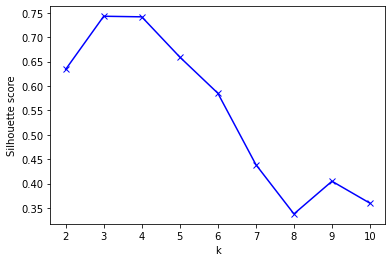

In [8]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### Inne, podobne metryki:  
Indeks Daviesa–Bouldina
<details>
<summary> Indeks Dunna (dla zainteresowanych — kliknij!) </summary>
    
$$ DI = \frac{ \underset{i, j}{\min} \delta (C_i, C_j)}{\underset{k}{\max} \Delta (C_k)} $$

Gdzie:  
$\delta (C_i, C_j)$ -- odległość między klastrami. Możemy ją liczyć na wiele sposóbów. Są to między innymi:
* Średnia odległość między punktami obu klastrów.
* Najmniejsza odległość między punktami obu klastrów.
* Maksymalna odległość między punktami obu klastrów.
* Odległośc między środkami klastrów.

$\Delta (C_k)$ -- wielkość klastra. Znowu mamy wiele pomysłów na jej wyznaczanie:
* Maksymalna odległość między punktami.
* Średnia odległość między punktami.
* Dwukrotność średniej odległości do środka (można o tym myśleć jako o czymś na wzór średnicy).

Indeks Dunna "patrzy" tylko na największy klaster i najmniejszą odległość między klastrami. Czyli możemy myśleć o tym jako o rozważaniu najgorszego przypadku. Z drugiej strony jeśli odpowiednich $\delta ()$ i $ \Delta () $ --  do pewnego stopnia uniezależniamy się od premiowania "okrągłych" klastrów.
</details>
Rand Indeks
<details>
<summary>Indeks Calińskiego-Harabasza znany jako Variance Ratio Criterion (dla zainteresowanych — kliknij!)</summary>
$$ CH = \frac{SS_B}{SS_W}*\frac{N-k}{k-1} $$
    
Gdzie:  
$SS_B$ - suma kwadratów odległości "międzygrupowych" jako miara rozrzutu powinna być jak największa  
$SS_W$ - suma kwadratów odległości "wewnątrzgrupowych" jako miara rozrzutu powinna być jak najmniejsza  
$N$ - liczba obserwacji  
$k$ - liczba klastrów
 </details>

### Metryki interpretowalne
>*Gdy dowolny wskaźnik zaczyna być traktowany jako cel, przestaje być dobrym wskaźnikiem.*  
>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Prawo Goodharta

Powyższe metryki dobrze sprawdzają się przy doborze liczby klastrów. Z drugiej strony są one trudne w interpretacji. Często mamy pewne oczekiwania wobec klastrów. Na przykład:
* Dobra separacja klastrów
* Małe odległości wewnątrz klastrów
* Klastry podobnej wielkości
* Dobra reprezentacja klastrów przez środki
* Stabilność klasteryzacji
* Duża gęstość klastrów


Często metryka, którą wybierzemy, jest związana z tym, czego szukamy. Przykłady metryk:
* Dobra separacja klastrów -> maksymalna odległość między punktami różnych klastrów
* Małe odległości wewnątrz klastrów -> średnia odległość między punktami
* Klastry podobnej wielkości -> wariancja wielkości klastrów (na przykład średniej odległości między punktami)
* Dobra reprezentacja klastrów przez ich środki -> średnia odległość między punktem w klastrze a środkiem
* Stabilność klasteryzacji -> bootstrap i frakcja punktów, które różnią się
* Duża gęstość klastrów -> największa odległość między punktami wewnątrz klastra

Niestety metryki te są wrażliwe na liczbę klastrów. Na przykład, jeśli naszym celem jest dobra reprezentacja punktów w klastrze przez środki, oczywiście najlepiej będzie, gdy każdy punkt będzie osobnym klastrem. A to chyba nie o to chodziło. Dlatego tego typu metryki najlepiej sprawdzają się, gdy porównujemy różne algorytmy, ale przy ustalonej liczbie klastrów.

In [9]:
# Zaimplementujmy zatem kilka wspomnianych metryk.
from scipy.spatial import distance
import numpy as np


def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)


print(f'Minimal distance between clusters = {count_clustering_scores(X, 4, KMeans, min_interclust_dist):.2f}.')
print(f'Average distance between points in the same class = '
      f'{count_clustering_scores(X, 4, KMeans, mean_inclust_dist):.2f}.')
print(f'Standard deviation of distance between points in the same class = '
      f'{count_clustering_scores(X, 4, KMeans, std_dev_of_inclust_dist):.3f}.')
print(f'Average distance to cluster center = '
      f'{count_clustering_scores(X, 4, KMeans, mean_dist_to_center):.2f}.')

Minimal distance between clusters = 0.55.
Average distance between points in the same class = 1.64.
Standard deviation of distance between points in the same class = 0.107.
Average distance to cluster center = 1.15.


##### Uwaga programistyczna:
Funkcje `_inclass_mean_dists()` i `mean_dist_to_center()` mają taką samą pętlę. Tak właściwie należałoby napisać wrapper, który robiłby naszą pętlę i przekazywać jako argument funkcję wykonującą ciało (odpowiednio liczenie średniej odległości między punktami i średniej odleglości od środka), ale być może zaciemniłoby to tematykę zajęć.

Dla zainteresowanych: jest to ten sam manewr, który użyliśmy w funkcji `count_clustering_scores()`.

### Klasteryzacja hierarchiczna
![](https://46gyn61z4i0t1u1pnq2bbk2e-wpengine.netdna-ssl.com/wp-content/uploads/2018/03/Hierarchical-clustering-2.png)
<div align="center">Źródło: https://www.displayr.com/what-is-hierarchical-clustering/</div>

Uwaga: trzeci obrazek na powyższej grafice jest błędny.

Powyżej pokazano koncepcję klasteryzacji aglomeracyjnej, ale na jakiej podstawie wybieramy, które klastry połączyć?  
Zasadniczo zawsze wybieramy połączenie tych klastrów, które są najbliżej siebie.
Jest kilka pomysłów określania tego, co znaczy „są blisko siebie”. Na przykład:
* Połączenie kompletne
* Połączenie pojedyncze
* Połączenie średnie
* Połączenie centroidalne
* Połączenie Warda — o ile wzrośnie wariancja nowego klastra względem sumy wariancji starych klastrów
![](https://ars.els-cdn.com/content/image/1-s2.0-S2300396016300799-gr6.jpg)
<div align="center">Źródło: <em>Tan, P.-N., Steinbach, M., & Kumar, V. (2005). Introduction to data mining. Boston:
Addison-Wesley</em></div>

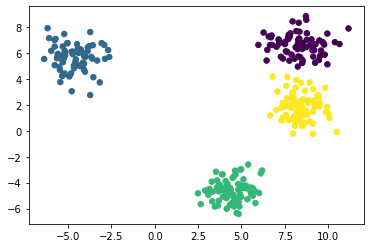

In [10]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=4)
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Co nam jeszcze daje klasteryzacja hierarchiczna: nie musimy znać liczby klastrów. Zauważmy, że model buduje całą hierarchię klastrów. Na przykład:

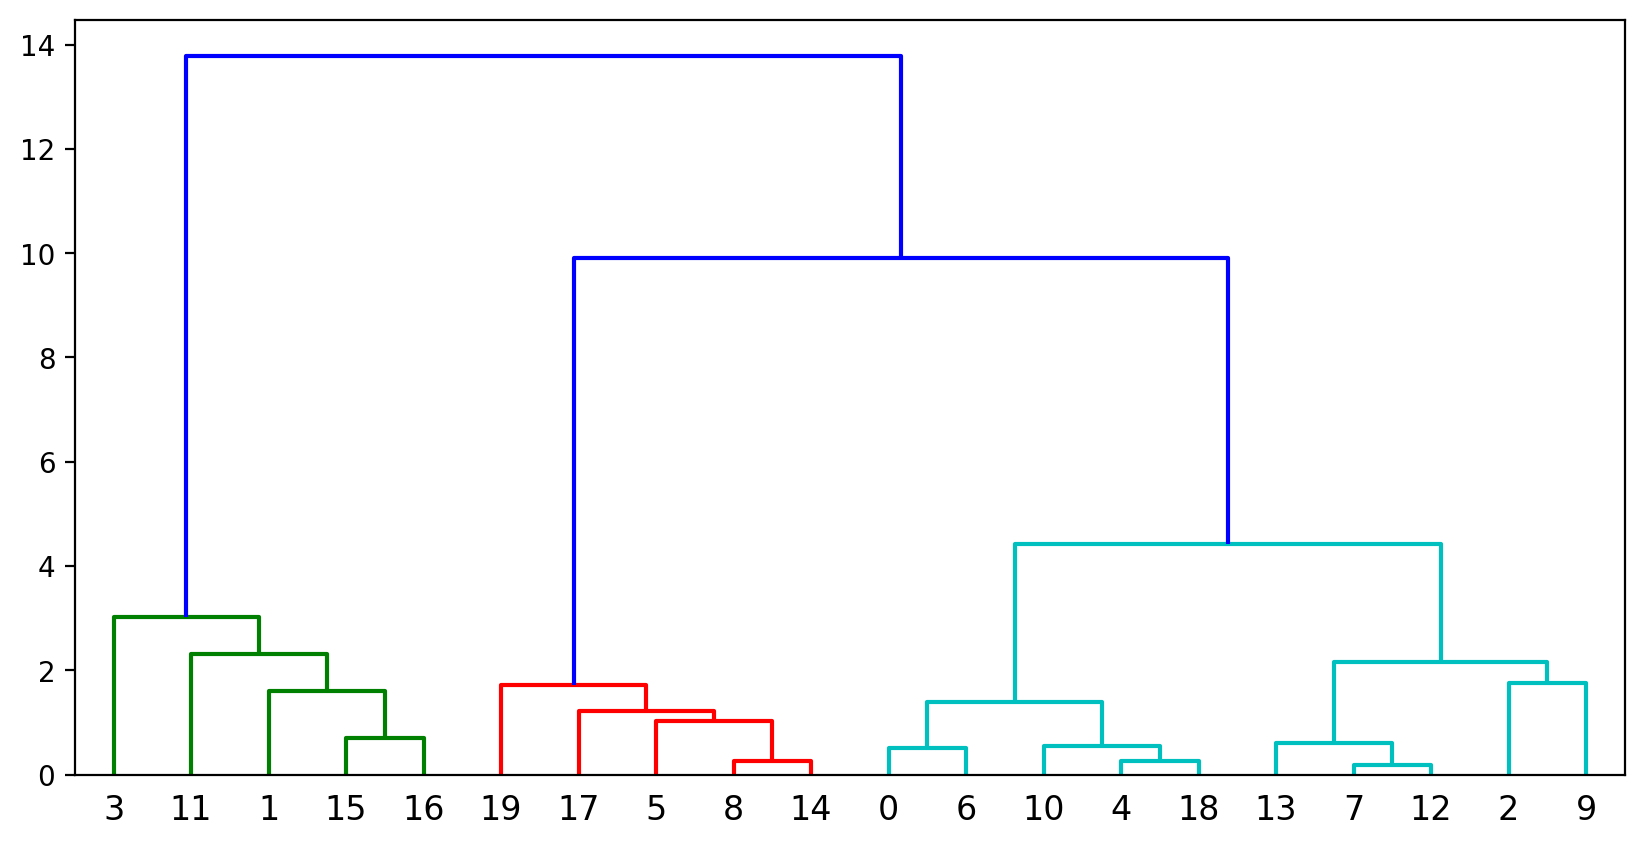

In [11]:
from scipy.cluster import hierarchy

# Generujemy nowe dane o mnjejszej liczbie punktów (dla czytelności)
X_small, _ = make_blobs(n_samples=20, centers=4, cluster_std=0.9, random_state=314)
Z = hierarchy.linkage(X_small, method='average')
plt.figure(figsize=(10, 5), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z)
plt.show()

Co nam to daje?  
Dzięki temu możemy nie podawać jawnie liczby klastrów, a powiedzieć na przykład:
> Interesują nas klastry, w których odległość między punktami będzie nie większa niż 6.25.

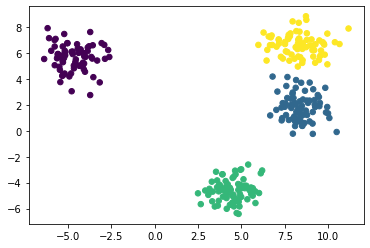

In [12]:
# A wtedy możemy zrobić tak:
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=6.25)
y = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Warto wspomnieć, że bardzo podobna do klasteryzacji aglomeracyjnej jest klasteryzacja deglomeracyjna.

W klasteryzacji aglomeracyjnej zaczynamy od pojedynczych punktów i łączymy je kolejno w klastry.
W klasteryzacji deglomeracyjnej zaczynamy od jednego „superklastra” zawierającego wszystkie punkty i dzielimy go na mniejsze klastry.

Jeśli spojrzymy na drzewo hierarchii, to w metodzie aglomeracyjnej jest ono budowane „od dołu”, w metodzie deglomeracyjnej „od góry”.

Metoda deglomeracyjna jest rzadko wykorzystywana ze względu na większą złożoność. Rozważmy szukanie skupień dla $n$ punktów. Już pierwszej iteracji musimy rozważyć $2^n$ możliwych podziałów.
Dla porównania metoda aglomeracyjna w pierwszej iteracji ma do przeanalizowania zaledwie $\frac{n (n-1)}{2}$ możliwych połączeń.

### A co z nieco bardziej wymagającym zbiorem?

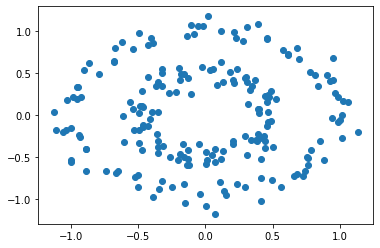

In [13]:
from sklearn.datasets import make_circles

X, _ = make_circles(factor = 0.5, noise=0.08, n_samples=200, random_state=3)
plt.scatter(X[:,0], X[:,1])
plt.show()

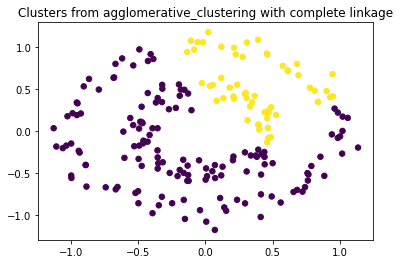

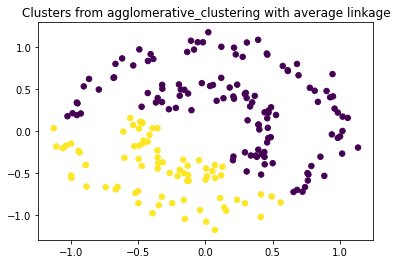

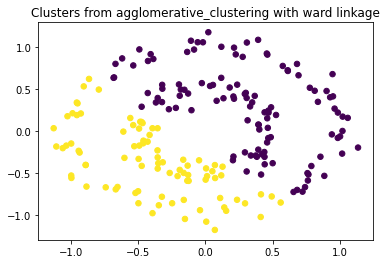

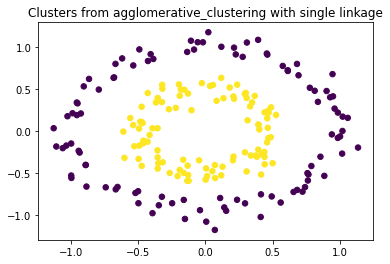

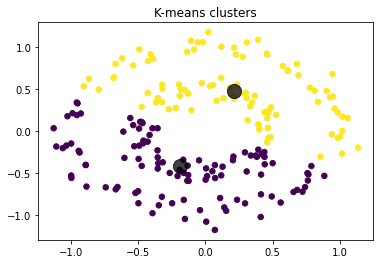

In [14]:
def plot_agglomerative_clustering(X, n_clusters, linkage):
    model = AgglomerativeClustering(n_clusters=2, linkage=linkage)
    y = model.fit_predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
    plt.title(f'Clusters from agglomerative_clustering with {linkage} linkage')
    plt.show()

for linkage in {'ward', 'complete', 'average', 'single'}:
    plot_agglomerative_clustering(X, n_clusters=2, linkage=linkage)
    
plot_kmeans_clusters(X, n_clusters=2)

In [15]:
import pandas as pd
from functools import partial


metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Kmeans': KMeans
         }

df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=2,
                                                                model=models[model_key],
                                                                score_fun=metrices[metric_key])
df

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Agglomerative ward linkage,0.108561,0.780815,0.056863,0.561813,0.347511
Agglomerative complete linkage,0.107776,0.757460,0.197141,0.552155,0.260237
Agglomerative average linkage,0.108561,0.776208,0.126496,0.559154,0.319070
Agglomerative single linkage,0.229022,0.969205,0.315891,0.747607,0.105414
Kmeans,0.107776,0.779855,0.003650,0.559196,0.362541


In [16]:
# Tutaj w wersji macierzowej, znowu: dla chętnych

# Rozpakowywujemy słowniki do list
# Jedna lista zawiera klucze, druga wartości
metrices_names, metrices_fun = list(metrices.keys()), list(metrices.values())
models_names, models_constructors = list(models.keys()), list(models.values())


# Stwórzmy macierz będącą iloczynem kartezjańskim modeli i metryk
# Wzdłuż osi 1. mamy różne modele
# Wzdłuż osi 2. -- różne metryki
# Tak właściwie to łącząc macierze, otrzymamy tensor, gdzie w 3. wymiarze mamy pary (metryka, model)
# W pythonie numerujemy od 0, więc żeby połączyć po 3 osi (matematycznie), jako numer osi podajemy 2.
arguments_array = np.stack(np.meshgrid(metrices_fun, models_constructors), axis=2)

# Przykładowa para (metryka, model):
print(arguments_array[0, 0, :])

# Tworzymy funkcję, która przyjmuję parę (metryka, model) i zwraca wartość metryki
# Moglibyśmy stworzyć tę funkcję normalnie, ale korzystamy z niej tylko raz, a tak jest zwięźle
benchmark_fun = lambda pair: count_clustering_scores(X=X, cluster_num=2, model=pair[1], score_fun=pair[0])

# Wreszcie używamy funkcji do par (metryka, model) we wcześniej stworzonej macierzy
scores_arr = np.apply_along_axis(benchmark_fun, axis=-1, arr=arguments_array)
pd.DataFrame(scores_arr, columns=metrices_names, index=metrices_names)

[<function min_interclust_dist at 0x7fafb87f18c8>
 functools.partial(<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>, linkage='ward')]


,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
min dist between clusters,0.108561,0.780815,0.056863,0.561813,0.347511
mean dist in clust,0.107776,0.757460,0.197141,0.552155,0.260237
std dev dist in clust,0.108561,0.776208,0.126496,0.559154,0.319070
mean dist to clust center,0.229022,0.969205,0.315891,0.747607,0.105414
silhouette,0.107776,0.779855,0.003650,0.559196,0.362541


### Dla zainteresowanych — materiały dodatkowe
Badanie porównawcze metryk:  
[Bolshakova and Azuaje, 2003](https://www.scss.tcd.ie/publications/tech-reports/reports.02/TCD-CS-2002-33.pdf)  
Wykład o weryfikacji jakości klasteryzacji:  
[Henning, 2016](https://www.youtube.com/watch?v=Mf6MqIS2ql4)